In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load dataset
df = pd.read_csv('Integrated_Dataset_Shaik_Mahammad_Ghouse.csv')


In [3]:
# Step 1: Prepare Data
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.sort_values('DateTime', inplace=True)


In [4]:
# Define features and target
target_col = 'Vehicles'
feature_cols = df.columns.drop(['DateTime', 'Vehicles'])

X = df[feature_cols]
y = df[target_col]


In [5]:
# Time-based split: 70% train, 30% validation
split_index = int(len(df) * 0.7)
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]


In [6]:
# Step 2: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [1.0]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 150, 200], 'subsample': [1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [7]:
# Best model
best_gb_model = grid_search.best_estimator_


In [8]:
# Step 3: Prediction on validation set
y_pred = best_gb_model.predict(X_val)


In [9]:
# Metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print("GBR MAE:", mae)
print("GBR RMSE:", rmse)
print("GBR R²:", r2)


GBR MAE: 3.1438326548495783
GBR RMSE: 5.367271845932317
GBR R²: 0.9585043048427699


In [10]:
# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_gb_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validated RMSE scores:", cv_rmse)
print("Average CV RMSE:", np.mean(cv_rmse))


Cross-validated RMSE scores: [4.01900817 5.3025713  4.89756144 4.91867063 5.0225294 ]
Average CV RMSE: 4.832068187263504


In [11]:
# LSTM Model
# Use only numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train_lstm = X_scaled[:split_index]
X_val_lstm = X_scaled[split_index:]
y_train_lstm = y_scaled[:split_index]
y_val_lstm = y_scaled[split_index:]


In [12]:
# Define LSTM model using Input layer to avoid warning
model = Sequential()
model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_val_lstm, y_val_lstm), verbose=1)

# Predict and inverse transform
y_pred_lstm = model.predict(X_val_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_val_lstm_inv = scaler.inverse_transform(y_val_lstm)


Epoch 1/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0030 - val_loss: 9.4738e-04
Epoch 2/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.1875e-04 - val_loss: 9.0502e-04
Epoch 3/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9384e-04 - val_loss: 8.1701e-04
Epoch 4/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6869e-04 - val_loss: 8.6502e-04
Epoch 5/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5712e-04 - val_loss: 7.9322e-04
Epoch 6/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2825e-04 - val_loss: 0.0011
Epoch 7/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7088e-04 - val_loss: 8.5837e-04
Epoch 8/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6393e-04 - val_loss: 8.0715e-04
Epoch 9/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3454e-04 - val_loss: 7.7463e-04
Epoch 10/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9778e-04 - val_loss: 8.1044e-04
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


In [13]:
# Metrics for LSTM
print("LSTM MAE:", mean_absolute_error(y_val_lstm_inv, y_pred_lstm_inv))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_val_lstm_inv, y_pred_lstm_inv)))
print("LSTM R²:", r2_score(y_val_lstm_inv, y_pred_lstm_inv))


LSTM MAE: 3.349168573400168
LSTM RMSE: 5.095809018182329
LSTM R²: 0.9625956470888056


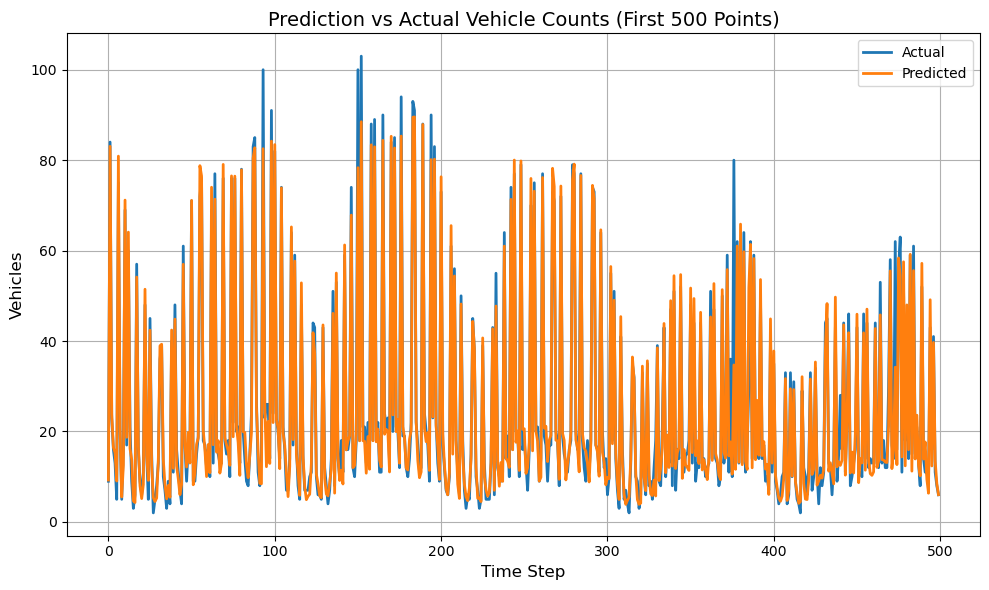

In [14]:
# Step 4: Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.plot(y_val.values[:500], label='Actual', linewidth=2)
plt.plot(y_pred[:500], label='Predicted', linewidth=2)
plt.title("Prediction vs Actual Vehicle Counts (First 500 Points)", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Vehicles", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Step 5: Cross-validation (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
rmse_scores = np.sqrt(-cv_scores)

print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std Dev of RMSE:", rmse_scores.std())


Cross-Validation RMSE Scores: [4.37015716 3.66918857 4.85506524 4.86018002 5.02658857]
Mean RMSE: 4.556235909558739
Std Dev of RMSE: 0.49485167349188736


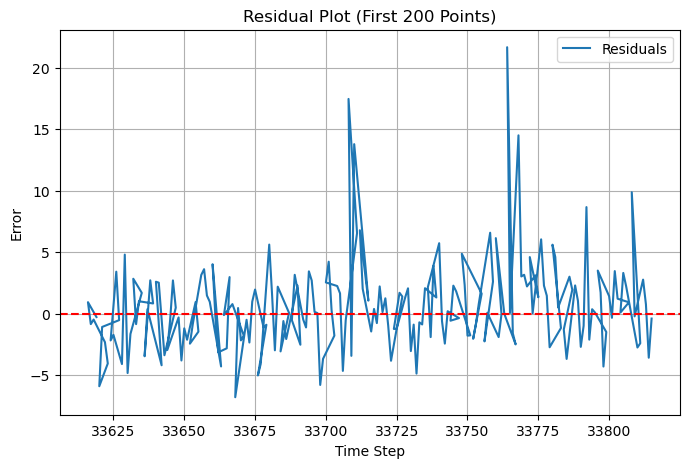

In [16]:
# Residual Plot
residuals = y_val - y_pred
plt.figure(figsize=(8, 5))
plt.plot(residuals[:200], label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot (First 200 Points)")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


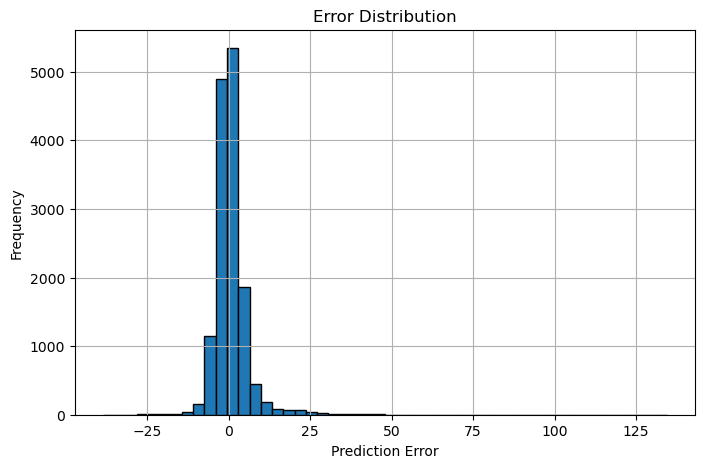

In [17]:
# Error Distribution
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title("Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
